# NY Airbnb listing data 2019

Initial exploration of the data.

Warren Boult

In [82]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression, SelectKBest, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures

import geohash

In [6]:
# Load in the data
df = pd.read_csv('./data/AB_NYC_2019.csv')

df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [7]:
# Let's look at a sample
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [8]:
# Let's create an exploratory report
profile = ProfileReport(df, title='Airbnb exploratory', explorative=True, plot={'histogram': {'bins': 30}})
profile.to_widgets()

### Initial thoughts about the data

* there are 48895 rows in the dataset, and 16 columns.
* there are 4 features with missing values: `name`, the listing name; `host_name`, the name of the property's host; `last_review`, the date of the last review given for the property; and `reviews_per_month`, the number of reviews given for the property per month since first being listed
* the `price` feature, the presumed target value has no missing values. There are however listings with a price of 0 which doesn't sound right, needs exploring further
* there are 3 features with a high enough cardinality that they warrant further exploration: `name`, `host_name` and `last_review`. The first two are text fields so they're suitable for further nlp analysis. `last_review` is a date field so could be bucketed perhaps. 
* `availability_365` feature is defined as 'number of days when listing is available for booking', however the majority of values are 0, so not sure exactly what this feature actually indicates, or whether it will be useful for prediction.

In [101]:
# Let's take a quick look at the properties with a price of 0, to see if there's any obvious reason why
print(df[df['price'] == 0][['host_name','name','latitude','longitude','neighbourhood','neighbourhood_group','availability_365']])

          host_name                                               name  \
23161      Kimberly  Huge Brooklyn Brownstone Living, Close to it all.   
25433        Anisha      ★Hostel Style Room | Ideal Traveling Buddies★   
25634  Martial Loft    MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)   
25753        Lauren                    Sunny, Quiet Room in Greenpoint   
25778       Aymeric      Modern apartment in the heart of Williamsburg   
25794       Adeyemi  Spacious comfortable master bedroom with nice ...   
25795       Adeyemi  Contemporary bedroom in brownstone with nice view   
25796       Adeyemi       Cozy yet spacious private brownstone bedroom   
26259        Qiuchi                              the best you can find   
26841        Sergii  Coliving in Brooklyn! Modern design / Shared room   
26866        Sergii             Best Coliving space ever! Shared room.   

       latitude  longitude       neighbourhood neighbourhood_group  \
23161  40.69023  -73.95428  Bedford-Stuyv

Nothing obvious about them, looks like bad data.

### Let's look at the location features.

`latitude`, `longitude`, `neighborhood`, `neighborhood_group`

General questions:
* what do these features look like? Common values, mean values, distribution
* let's consider these features given what we know about New York

Key questions:
* do we need to make use of both the lat/long features _and_ the neighborhood features? Does one or the other have a stronger correlation with the target variable?
* related, are lat/long features worth bucketing to make them categorical features? Does this achieve something similar to one of the neighborhood features

In [99]:
latitude = df['latitude']
longitude = df['longitude']
neighborhood = df['neighbourhood']
neighborhood_group = df['neighbourhood_group']

price = df['price']

### Latitude/longtitude

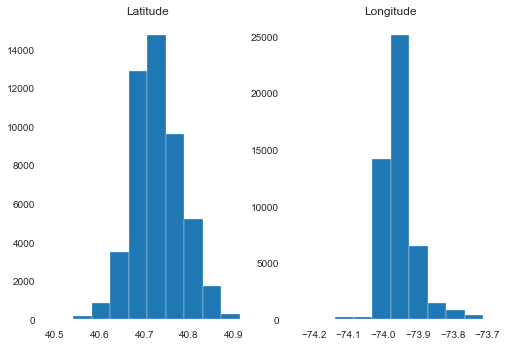

In [10]:
plt.subplot(1,2,1)
plt.hist(latitude)
plt.title('Latitude')

plt.subplot(1,2,2)
plt.hist(longitude)
plt.title('Longitude')

plt.show()


The latitude (north/southness) is spread over a smaller range  than the longitude (east/westness).
The most properties are all within the latitude range -74 to -73.9. Let's get a bit more granular as the above histograms aren't informative enough.

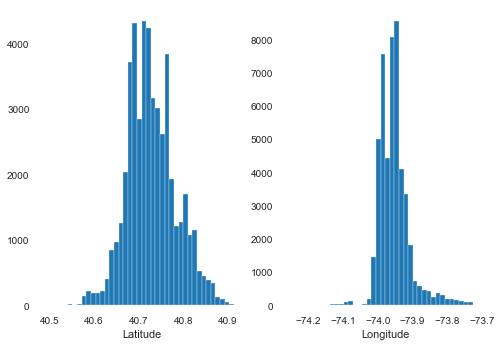

In [11]:
plt.subplot(1,2,1)
plt.hist(latitude,bins=40)
plt.xlabel('Latitude')

plt.subplot(1,2,2)
plt.hist(longitude,bins=40)
plt.xlabel('Longitude')

plt.show()


Looks like we might have a few outliers at the extremities of the longitude

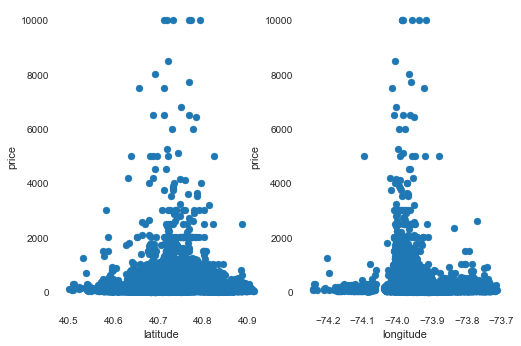

In [12]:
plt.subplot(1,2,1)
plt.scatter(latitude,price)
plt.xlabel('latitude')
plt.ylabel('price')

plt.subplot(1,2,2)
plt.scatter(longitude,price)
plt.xlabel('longitude')
plt.ylabel('price')
plt.show()

As is to be expected, the most expensive properties are right in the centre of New York, and decrease in price as we get further away, in a sort of normal distribution. Clear non-linear correlations between both latitude/longitude, and price.

### Neighbourhood

In [13]:
n_vc = neighborhood.value_counts()
n_vc

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Rossville                1
New Dorp                 1
Fort Wadsworth           1
Richmondtown             1
Willowbrook              1
Name: neighbourhood, Length: 221, dtype: int64

In [14]:
df.groupby('neighbourhood')['price'].mean().sort_values()

neighbourhood
Bull's Head        47.333333
Hunts Point        50.500000
Tremont            51.545455
Soundview          53.466667
New Dorp           57.000000
                     ...    
Riverdale         442.090909
Sea Gate          487.857143
Tribeca           490.638418
Woodrow           700.000000
Fort Wadsworth    800.000000
Name: price, Length: 221, dtype: float64

The cardinality of the `neighbourhood` feature is relatively high, at 221. We can see that the majority are found in the Williamsburg neighbourhood, and there are several neighbourhoods containing only one property. Let's find out just how many of those neighbourhoods there are.

In [15]:
# Number of neighbourhoods with only one property
n_vc[n_vc==1].count()

6

Only 6 which is convenient. Doesn't diminish the potential usefulness of the feature.

What about neighbourhoods with a considerable amount of properties? Say, more than 10?

In [16]:
# Number of neighbourhoods with > 10 properties
n_vc[n_vc>10].count()

162

Majority of neighbourhoods have >10 properties. 60 neighbourhoods don't. All good.

In [17]:
common_neighbourhoods = n_vc[:10].index.values
print(common_neighbourhoods)

df_common_neighbourhoods = df[df['neighbourhood'].isin(common_neighbourhoods)]
df_common_neighbourhoods

['Williamsburg' 'Bedford-Stuyvesant' 'Harlem' 'Bushwick' 'Upper West Side'
 "Hell's Kitchen" 'East Village' 'Upper East Side' 'Crown Heights'
 'Midtown']


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


Text(0, 0.5, 'price')

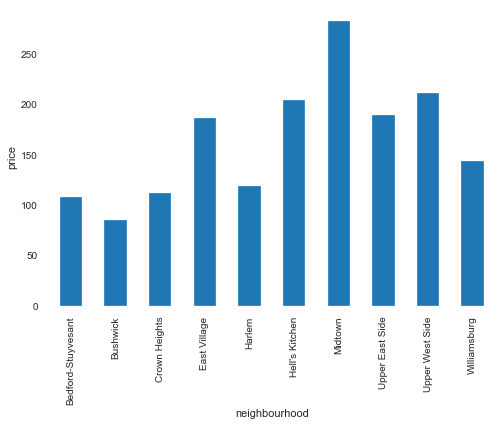

In [18]:
avg_price = df_common_neighbourhoods.groupby('neighbourhood')['price'].mean()
avg_price.plot.bar()
plt.ylabel('price')

There's reasonable variance in price across the values of this feature; certainly looks informative.

Let's take a look at the `neighbourhood_group` feature. This feature captures the higher-level neighbourhood, covering more distance.

### Neighbourhood group

In [19]:
neighborhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

Staten Island doesn't have many property listings compared to the others.

In [20]:
# Let's look at the average price per neighbourhood group
avg_price = df.groupby('neighbourhood_group')['price'].mean()

print(avg_price.sort_values())

neighbourhood_group
Bronx             87.496792
Queens            99.517649
Staten Island    114.812332
Brooklyn         124.383207
Manhattan        196.875814
Name: price, dtype: float64


Text(0, 0.5, 'price')

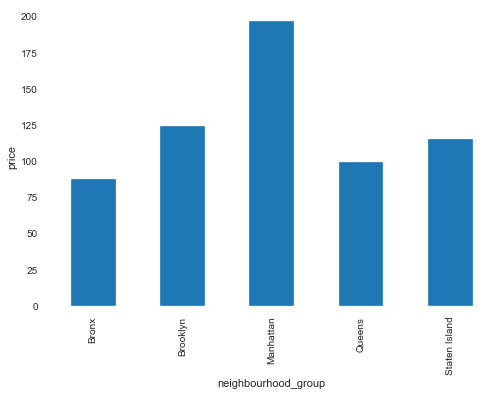

In [21]:
avg_price.plot.bar()
plt.ylabel('price')

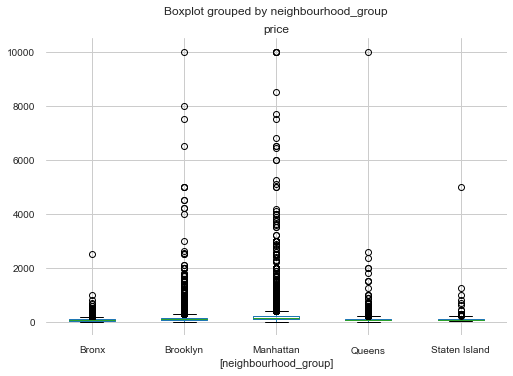

In [22]:
df[['neighbourhood_group','price']].boxplot(by='neighbourhood_group')

As we can see, most of the most expensive properties are in Manhattan, ie the center of NY. The mean price value for Manhattan is certainly considerably higher than other neighbourhood groups, at $196, however it has a large spread of prices. Looks like it would be an informative feature for predicting price. However, considering the large skew in properties being located either in Manhattan or Brooklyn, and the overall low cardinality of this feature, it's probably not going to be _too_ useful in predicting price well.

Let's take a look at which of these location features are most indicative of the target variable, `price`.

In [57]:
def simple_feature_importance(X, y, func=mutual_info_regression, discrete=None):

    if func == mutual_info_regression:
        # Score each of the features
        fit = func(X, y,discrete_features=discrete)
    else:
        fit, _ = func(X, y)
        
    # Organize and return the scores
    featureScores = pd.DataFrame([X.columns, fit]).T
    featureScores.columns = ['Feature', 'Score']
    return featureScores.sort_values(
            'Score', ascending=False).set_index('Feature') 

In [62]:
df['neighbourhood_enc'] = LabelEncoder().fit_transform(df['neighbourhood'])
df['neighbourhood_grp_enc'] = LabelEncoder().fit_transform(df['neighbourhood_group'])

feature_importance_mi = simple_feature_importance(df[['neighbourhood_enc', 'neighbourhood_grp_enc', 'latitude', 'longitude']], df['price'], discrete=[True,True,False,False])
feature_importance_f = simple_feature_importance(df[['latitude', 'longitude']], df['price'], f_regression)

print("Mutual information")
print(feature_importance_mi)

print("\nF regression")
print(feature_importance_f)

Mutual information
                           Score
Feature                         
neighbourhood_enc       0.238869
longitude               0.164326
latitude                0.127605
neighbourhood_grp_enc  0.0837087

F regression
             Score
Feature           
longitude  1125.71
latitude   56.3815


We already know that the latitude and longitude are not linearly correlated with the price, so their f-regression scores are not so useful.

However wrt the neighbourhood features, these scores seem to confirm our earlier suspicions that `neighbourhood_group` may not be such a useful feature, whereas `neighbourhood` is potentially quite informative of the price.

It isn't surprising that a fairly high-level, location-based feature wouldn't offer much information in comparison to the more fine-grained location features. One hypothesis as to why the `neighbourhood_group` feature may influence price independently of location, may have been the 'history'/'prestige' factor of certain neighbourhoods. However doesn't appear to be the case.

Let's look into bucketing the lat/long features to see if that improves their informativeness.

In [67]:
df['latitude_bucketed'] = pd.cut(df['latitude'],20, labels=False)
df['longitude_bucketed'] = pd.cut(df['longitude'],20, labels=False)

print(df['longitude_bucketed'].head())

print("Mutual information")
print(simple_feature_importance(df[['neighbourhood_enc', 'neighbourhood_grp_enc', 'latitude_bucketed', 'longitude_bucketed']], df['price'], discrete=[True,True,True,True]))

print("\nF regression")
print(simple_feature_importance(df[['latitude_bucketed', 'longitude_bucketed']], df['price'], f_regression))

0    10
1     9
2    11
3    10
4    11
Name: longitude_bucketed, dtype: int64
Mutual information
                           Score
Feature                         
neighbourhood_enc       0.234004
longitude_bucketed      0.127092
latitude_bucketed      0.0966652
neighbourhood_grp_enc  0.0858756

F regression
                      Score
Feature                    
longitude_bucketed  1091.31
latitude_bucketed   53.9449


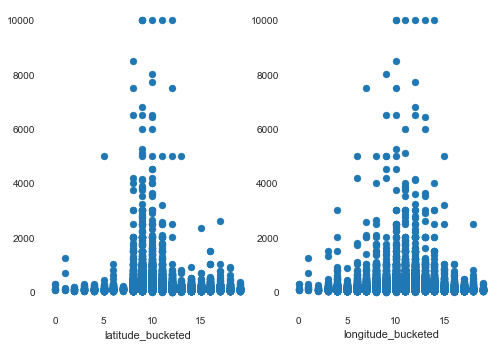

In [68]:
plt.subplot(1,2,1)
plt.scatter(df['longitude_bucketed'],df['price'])
plt.xlabel('latitude_bucketed')

plt.subplot(1,2,2)
plt.scatter(df['latitude_bucketed'],df['price'])
plt.xlabel('longitude_bucketed')

plt.show()

Bucketing the lat/long features decreases their informativeness. Let's discard that idea.

Now, these features are highly interrelated, and it feels likely that combining them as features will prove predictive of price. Let's try that.

In [97]:
# Basic feature combination by adding and multiplying the lat/long features
df['latlon_add'] = df.apply(lambda x: x['latitude']+x['longitude'],axis=1)
df['latlon_mult'] = df.apply(lambda x: x['latitude']*x['longitude'],axis=1)

In [95]:
feature_importance_mi = simple_feature_importance(df[['latlon_add', 'latlon_mult','latitude', 'longitude']], df['price'], discrete=[False,False,False,False])
feature_importance_f = simple_feature_importance(df[['latlon_add', 'latlon_mult','latitude', 'longitude']], df['price'], f_regression)


print("Mutual information")
print(feature_importance_mi)

print("\nF regression")
print(feature_importance_f)

Mutual information
                 Score
Feature               
longitude     0.164702
latlon_mult   0.143242
latitude      0.127731
latlon_add   0.0865664

F regression
               Score
Feature             
longitude    1125.71
latlon_mult  468.281
latlon_add   228.633
latitude     56.3815


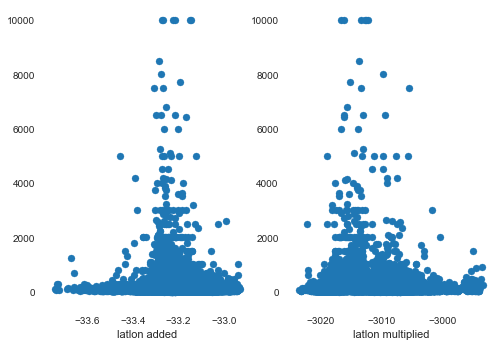

In [96]:
plt.subplot(1,2,1)
plt.scatter(df['latlon_add'],df['price'])
plt.xlabel('latlon added')

plt.subplot(1,2,2)
plt.scatter(df['latlon_mult'],df['price'])
plt.xlabel('latlon multiplied')

plt.show()

We can see the multiplied feature spreads the data better, and offers a better MI than just latitude on its own. Something to explore further in feature creation.

### Location features summary

* the raw `latitude` and `longitude` features are indicative of price, both in terms of a clear non-linear correlation with the price, and in terms of the mutual information between each and the target. Bucketing them isn't useful, but combining them looks to add some value.
* the higher level `neighbourhood_group` feature doesn't look too informative - it only has a cardinality of 5 and the large majority of properties are found in 2 of those categories
* however, the `neighbourhood` feature looks to have real predictive value, with the highest MI score of the location features. Definitely worth including this and seeing if it offers additional predictive power to the lat/lon
* the `neighbourhood` feature may need some cleaning if it is to be used - there are several categories with only one value.